# Purpose

The purpose of this notebook is to explore the usage of [auto-sklearn](https://automl.github.io/auto-sklearn/master/) for automated algorithm selection and hyperparameter tuning.

## Data

The CA housing data will be used for this example, which is a simple regressiont task. It will be loaded from the sklearn data loader. I'll split off 20% into a test set which `auto-sklearn` won't see during selection and tuning.

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd

housing = fetch_california_housing()

X_train, X_test, y_train, y_test = train_test_split(
    housing.data, housing.target, test_size=0.2
)

pd.DataFrame(X_train, columns=housing.feature_names).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.863213,28.607013,5.435929,1.098311,1421.535187,3.103588,35.632925,-119.566449
std,1.892192,12.586631,2.617797,0.508852,1085.579217,11.598327,2.135489,2.005619
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.260000
25%,2.559875,18.000000,4.440973,1.005882,785.000000,2.428532,33.940000,-121.800000
50%,3.531750,29.000000,5.227585,1.048611,1165.500000,2.817672,34.260000,-118.500000
75%,4.741375,37.000000,6.048902,1.099367,1725.250000,3.281481,37.720000,-118.000000
max,15.000100,52.000000,141.909091,34.066667,16122.000000,1243.333333,41.950000,-114.470000


# Select and Fit Regressor

Now I'll let `auto-sklearn` select a regressor and tune hyperparameters.  I'll give it 10 minutes for the task and I'll use mean squared error for the metric.

In [12]:
import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task = 600,
    tmp_folder = "/tmp/autosklearn_regression_example_tmp"
)
automl.fit(X_train, y_train, dataset_name="CA Housing")

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=60, time_left_for_this_task=600,
                     tmp_folder='/tmp/autosklearn_regression_example_tmp')

# View the Model Leaderboard


In [14]:
automl.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
5,1,0.10,gradient_boosting,0.170541,8.954080
7,2,0.02,gradient_boosting,0.170775,3.923948
15,3,0.28,gradient_boosting,0.171231,4.121505
36,4,0.18,gradient_boosting,0.172118,6.252859
6,5,0.22,gradient_boosting,0.173452,8.697344
47,6,0.02,gradient_boosting,0.176753,15.958781
19,7,0.06,gradient_boosting,0.178071,2.157974
46,8,0.08,gradient_boosting,0.178671,2.899472
30,9,0.04,gradient_boosting,0.178881,15.132808


# View Final Ensemble

In [15]:
automl.show_models()

{5: {'model_id': 5, 'rank': 1, 'cost': 0.1705412164216238, 'ensemble_weight': 0.1, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7ff435c37640>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7ff435c37580>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7ff435c37310>, 'sklearn_regressor': HistGradientBoostingRegressor(l2_regularization=1.3053128884667706e-10,
                              learning_rate=0.05594167483605857, max_iter=512,
                              max_leaf_nodes=85, min_samples_leaf=10,
                              n_iter_no_change=4, random_state=1,
                              validation_fraction=None, warm_start=True)}, 6: {'model_id': 6, 'rank': 2, 'cost': 0.17345160413346683, 'ensemble_weight': 0.22, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice

# Score the Final Model

In [13]:
from sklearn.metrics import mean_squared_error

train_predictions = automl.predict(X_train)
print("Train MSE:", mean_squared_error(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, test_predictions))

Train MSE: 0.09253990016835716
Test MSE: 0.17995909199317583


# View Residuals

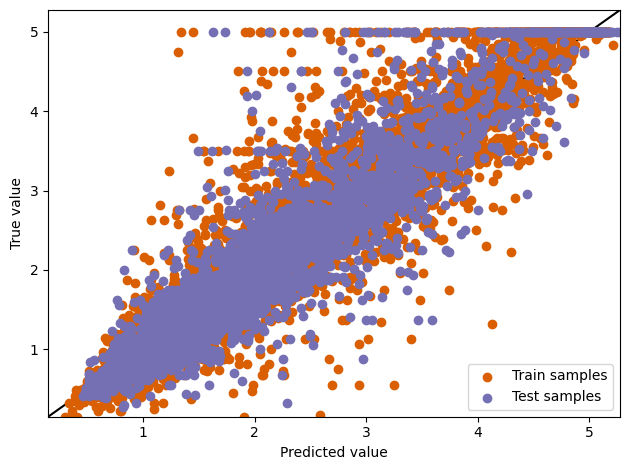

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plot_min = np.min(np.concatenate([test_predictions, train_predictions, y_train, y_test]))
plot_max = np.max(np.concatenate([test_predictions, train_predictions, y_train, y_test]))

plt.scatter(train_predictions, y_train, label="Train samples", c="#d95f02")
plt.scatter(test_predictions, y_test, label="Test samples", c="#7570b3")
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([plot_min, plot_max], [plot_min, plot_max], c="k", zorder=0)
plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])
plt.tight_layout()
plt.show()